# Coursework 2 for Cardiac MR Image Segmentation (2020-2021)

After you have gone through the coursework description, this tutorial is designed to further helps you understand the problem and therefore enable you to propose a good solution for this coursework. You will learn:

* how to load and save images with OpenCV
* how to train a segmentation model with Pytorch
* how to evaluate the trained model

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
!pip install torch
!pip install -u numpy



Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


## 1. Load, show, and save images with OpenCV

> Indented block



OpenCV is an open-source computer vision library which helps us to manipulate image data. In this section, we will cover:
* Loading an image from file with imread()
* Displaying the image with matplotlib plt.imshow()
* Saving an image with imwrite()

For a more comprehensive study of OpenCV, we encourage you to check the official [OpenCV documentation](https://docs.opencv.org/master/index.html).

In [ ]:
!unzip CW2.zip

Archive:  CW2.zip
   creating: CW2/
  inflating: CW2/.DS_Store           
  inflating: CW2/._.DS_Store         
  inflating: CW2/._Dockerfile        
   creating: CW2/data/
   creating: CW2/data/test/
   creating: CW2/data/test/image/
 extracting: CW2/data/test/image/cmr121.png  
 extracting: CW2/data/test/image/cmr122.png  
 extracting: CW2/data/test/image/cmr123.png  
 extracting: CW2/data/test/image/cmr124.png  
 extracting: CW2/data/test/image/cmr125.png  
 extracting: CW2/data/test/image/cmr126.png  
 extracting: CW2/data/test/image/cmr127.png  
 extracting: CW2/data/test/image/cmr128.png  
 extracting: CW2/data/test/image/cmr129.png  
 extracting: CW2/data/test/image/cmr130.png  
 extracting: CW2/data/test/image/cmr131.png  
 extracting: CW2/data/test/image/cmr132.png  
 extracting: CW2/data/test/image/cmr133.png  
 extracting: CW2/data/test/image/cmr134.png  
 extracting: CW2/data/test/image/cmr135.png  
 extracting: CW2/data/test/image/cmr136.png  
 extracting: CW2/data/test/im

In [ ]:
from matplotlib import pyplot as plt
def show_image_mask(img, mask, cmap='gray'): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')

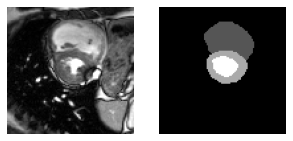

True

In [ ]:
import os
import cv2 #import OpenCV

data_dir = 'CW2/data/train' #'./data/train'
image = cv2.imread(os.path.join(data_dir,'image','cmr100.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr100_mask.png'), cv2.IMREAD_UNCHANGED)
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
cv2.imwrite(os.path.join('./','cmr100.png'), mask*1)

Note: You will no doubt notice that the mask images appear to be completely black with no sign of any segmentations. This is because the max intensity of pixels in an 8-bit png image is 255 and your image viewer software only sees 255 as white. For those values close to zero, you will only see dark values. This is the case for our masks as the background, the right ventricle, the myocardium, and the left ventricle in each image are 0, 1, 2, and 3, respectively. All of which are close to zero. If we multiply the original mask by 85 and save the result to the directory where this code is, we can see the heart indeed shows up.

## 2 Define a segmentation model with Pytorch

In this section, we expect you to learn how to:
* Define a Segmentation Model
* Define a DataLoader that inputs images to the Model
* Define training parameters and train the model
* Test the trained model with a new input image

### 2.1 Define a DataLoader

Below we provide you with a dataloader to use in your assigment. You will only need to focus on the development of your model and loss function.



In [ ]:
import torch
import torch.utils.data as data
import cv2
import os
from glob import glob
import torch.nn as nn
import torch.nn.functional as F

class TrainDataset(data.Dataset):
    def __init__(self, root=''):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))


    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float()

    def __len__(self):
        return len(self.img_files)


### 2.2 Define a Segmenatation Model

You will need to define your CNN model for segmentation below

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module
from torch.nn import Sequential
from torch.nn import Conv2d, Dropout2d, MaxPool2d, ReLU, UpsamplingNearest2d
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels #number of input channels to the network (for us this is 1)
        self.n_classes = n_classes #number of output channels to the network (for us this is 4)
        self.bilinear = bilinear #whether we want bilinear or traditional upsampling
        #initialising the basic blocks of the network
        self.inc = DoubleConv(n_channels, 64) #block on the top left of the network architecture
        self.down1 = Down(64, 128) #first downsampling block
        self.down2 = Down(128, 256) #second downsampling block
        self.down3 = Down(256, 512) #third downsampling block
        factor = 2 if bilinear else 1 #needed to get correct number of channels for the final downsampling and the upsampling layers depending on the upsampling method
        self.down4 = Down(512, 1024 // factor) #forth downsampling block
        self.up1 = Up(1024, 512 // factor, bilinear) #first upsampling block
        self.up2 = Up(512, 256 // factor, bilinear) #second upsampling block
        self.up3 = Up(256, 128 // factor, bilinear) #third upsampling block
        self.up4 = Up(128, 64, bilinear) #fourth upsampling block
        self.outc = OutConv(64, n_classes) #final layer mapping each 64- component feature vector to the desired number of classes (4 in our case)
  #the forward path following the logic defined in the paper
    def forward(self, x):
        x1 = self.inc(x) #block on the top left of the network architecture
        x2 = self.down1(x1) #first downsampling block
        x3 = self.down2(x2) #second downsampling block
        x4 = self.down3(x3) #third downsampling block
        x5 = self.down4(x4) #forth downsampling block
        x = self.up1(x5, x4) #first upsampling block (a concatenation with the correspondingly cropped feature map from the contracting path also happens here)
        x = self.up2(x, x3) #second upsampling block (a concatenation with the correspondingly cropped feature map from the contracting path also happens here)
        x = self.up3(x, x2) #third upsampling block (a concatenation with the correspondingly cropped feature map from the contracting path also happens here)
        x = self.up4(x, x1) #fourth upsampling block (a concatenation with the correspondingly cropped feature map from the contracting path also happens here)
        out = self.outc(x) #final layer mapping each 64- component feature vector to the desired number of classes (4 in our case)
        return out

class DoubleConv(nn.Module):
    # double convolution blocks, consisting of a convolutional layer, batch normalisation and a ReLU, repeated twice
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1), #convolutional layer, padding added to make sure edge detection works properly and necessary to maintain the resolution of the original image during the convolution phase and not to lose any pixels
            nn.BatchNorm2d(mid_channels), #batch normalisation (regularisation)
            nn.ReLU(inplace=True), #ReLU layer, inplace=True means that it modifies the input directly
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1), #convolutional layer, padding added to make sure edge detection works properly and necessary to maintain the resolution of the original image during the convolution phase and not to lose any pixels
            nn.BatchNorm2d(out_channels), #batch normalisation (regularisation)
            nn.ReLU(inplace=True)  #ReLU layer, inplace=True means that it modifies the input directly
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    #defining the downsampling blocks, consisting of downscaling with maxpool and a double convolutional layer defined earlier

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), #maxpooling (kernel size and stride 2)
            DoubleConv(in_channels, out_channels) #double convolutional layer defined earlier
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    #upscaling depending on selected method then double convolutional layer with appropriate number of channels
    #offers different (bilinear) upsampling than original paper
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        #if the mode is bilinear, we use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) #doing bilinear upsampling (align_corners makes "the corner pixels of the input and output tensors aligned, and thus preserving the values at those pixels" from torch Upsample documentation)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2) #double convolutional layer defined earlier with the appropriate number of channels
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2) #doing transpose convolution as upscaling as described in the original paper
            self.conv = DoubleConv(in_channels, out_channels) #double convolutional layer defined earlier

    def forward(self, x1, x2):
        x1 = self.up(x1) # doing the chosen upsampling
        # calculating the difference in the dimensions of the feature maps
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        # padding the feature map so that the dimensions match to concatenate it with the correspondingly cropped feature map from the contracting path
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1) #concatenating the feature map with the correspondingly cropped feature map from the contracting path
        return self.conv(x) #double convolution


class OutConv(nn.Module):
  #final layer mapping each 64- component feature vector to the desired number of classes (4 in our case)
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) #a simple convolutional layer to obtain the required number of classes from the 64-component feature vector

    def forward(self, x):
        return self.conv(x)


# We can now create a model using your defined segmentation model

model=UNet(1,4)



In [ ]:
import torchvision.models as models
vgg16_dims = [(64, 64, 'M'),                                # Stage - 1
              (128, 128, 'M'),                              # Stage - 2
              (256, 256, 256,'M'),                          # Stage - 3
              (512, 512, 512, 'M'),                         # Stage - 4
              (512, 512, 512, 'M')]                         # Stage - 5
decoder_dims = [('U', 512, 512, 512),                       # Stage - 5
                ('U', 512, 512, 512),                       # Stage - 4
                ('U', 256, 256, 256),                       # Stage - 3
                ('U', 128, 128),                            # Stage - 2
                ('U', 64, 64)]                              # Stage - 1

class SegNet(nn.Module):
    def __init__(self):
        super(SegNet, self).__init__()
        self.input_channels = 1
        self.output_channels = 4 #Number of different regions to classify
        self.num_channels = 1
        self.vgg16 = models.vgg16(pretrained=True)

        # Encoder layers
        self.encoder_conv_00 = nn.Sequential(*[
                                               nn.Conv2d(in_channels=self.input_channels,
                                                          out_channels=64,
                                                          kernel_size=3,
                                                          padding=1),
                                               nn.BatchNorm2d(64)
                                               ])
        self.encoder_conv_01 = nn.Sequential(*[
                                               nn.Conv2d(in_channels=64,
                                                          out_channels=64,
                                                          kernel_size=3,
                                                          padding=1),
                                               nn.BatchNorm2d(64)
                                               ])
        self.encoder_conv_10 = nn.Sequential(*[
                                               nn.Conv2d(in_channels=64,
                                                          out_channels=128,
                                                          kernel_size=3,
                                                          padding=1),
                                               nn.BatchNorm2d(128)
                                               ])
        self.encoder_conv_11 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=128,
                                                          out_channels=128,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(128)
                                                ])
        self.encoder_conv_20 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=128,
                                                          out_channels=256,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(256)
                                                ])
        self.encoder_conv_21 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=256,
                                                          out_channels=256,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(256)
                                                ])
        self.encoder_conv_22 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=256,
                                                          out_channels=256,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(256)
                                                ])
        self.encoder_conv_30 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=256,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_31 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_32 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_40 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_41 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_42 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.init_vgg_weigts()

        # Decoder layers
        self.decoder_convtr_42 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_41 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_40 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_32 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_31 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_30 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=256,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(256)
                                               ])
        self.decoder_convtr_22 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=256,
                                                                   out_channels=256,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(256)
                                               ])
        self.decoder_convtr_21 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=256,
                                                                   out_channels=256,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(256)
                                               ])
        self.decoder_convtr_20 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=256,
                                                                   out_channels=128,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(128)
                                               ])
        self.decoder_convtr_11 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=128,
                                                                   out_channels=128,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(128)
                                               ])
        self.decoder_convtr_10 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=128,
                                                                   out_channels=64,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(64)
                                               ])
        self.decoder_convtr_01 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=64,
                                                                   out_channels=64,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(64)
                                               ])
        self.decoder_convtr_00 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=64,
                                                                   out_channels=self.output_channels,
                                                                   kernel_size=3,
                                                                   padding=1)
                                               ])

    def forward(self, input_img):
        """
        Forward pass `input_img` through the network
        """
        input_img = input_img.repeat(1, 3, 1, 1)  #SegNet takes an RGB image, so for convienience the greyscale image is repeated 3 times to create an input image of depth 3
        # Encoder
        # Encoder Stage - 1
        dim_0 = input_img.size()
        x_00 = F.relu(self.encoder_conv_00(input_img))
        x_01 = F.relu(self.encoder_conv_01(x_00))
        x_0, indices_0 = F.max_pool2d(x_01, kernel_size=2, stride=2, return_indices=True)
        # Encoder Stage - 2
        dim_1 = x_0.size()
        x_10 = F.relu(self.encoder_conv_10(x_0))
        x_11 = F.relu(self.encoder_conv_11(x_10))
        x_1, indices_1 = F.max_pool2d(x_11, kernel_size=2, stride=2, return_indices=True)
        # Encoder Stage - 3
        dim_2 = x_1.size()
        x_20 = F.relu(self.encoder_conv_20(x_1))
        x_21 = F.relu(self.encoder_conv_21(x_20))
        x_22 = F.relu(self.encoder_conv_22(x_21))
        x_2, indices_2 = F.max_pool2d(x_22, kernel_size=2, stride=2, return_indices=True)
        # Encoder Stage - 4
        dim_3 = x_2.size()
        x_30 = F.relu(self.encoder_conv_30(x_2))
        x_31 = F.relu(self.encoder_conv_31(x_30))
        x_32 = F.relu(self.encoder_conv_32(x_31))
        x_3, indices_3 = F.max_pool2d(x_32, kernel_size=2, stride=2, return_indices=True)
        # Encoder Stage - 5
        dim_4 = x_3.size()
        x_40 = F.relu(self.encoder_conv_40(x_3))
        x_41 = F.relu(self.encoder_conv_41(x_40))
        x_42 = F.relu(self.encoder_conv_42(x_41))
        x_4, indices_4 = F.max_pool2d(x_42, kernel_size=2, stride=2, return_indices=True)

        # Decoder
        dim_d = x_4.size()
        # Decoder Stage - 5
        x_4d = F.max_unpool2d(x_4, indices_4, kernel_size=2, stride=2, output_size=dim_4)
        x_42d = F.relu(self.decoder_convtr_42(x_4d))
        x_41d = F.relu(self.decoder_convtr_41(x_42d))
        x_40d = F.relu(self.decoder_convtr_40(x_41d))
        dim_4d = x_40d.size()
        # Decoder Stage - 4
        x_3d = F.max_unpool2d(x_40d, indices_3, kernel_size=2, stride=2, output_size=dim_3)
        x_32d = F.relu(self.decoder_convtr_32(x_3d))
        x_31d = F.relu(self.decoder_convtr_31(x_32d))
        x_30d = F.relu(self.decoder_convtr_30(x_31d))
        dim_3d = x_30d.size()
        # Decoder Stage - 3
        x_2d = F.max_unpool2d(x_30d, indices_2, kernel_size=2, stride=2, output_size=dim_2)
        x_22d = F.relu(self.decoder_convtr_22(x_2d))
        x_21d = F.relu(self.decoder_convtr_21(x_22d))
        x_20d = F.relu(self.decoder_convtr_20(x_21d))
        dim_2d = x_20d.size()
        # Decoder Stage - 2
        x_1d = F.max_unpool2d(x_20d, indices_1, kernel_size=2, stride=2, output_size=dim_1)
        x_11d = F.relu(self.decoder_convtr_11(x_1d))
        x_10d = F.relu(self.decoder_convtr_10(x_11d))
        dim_1d = x_10d.size()
        # Decoder Stage - 1
        x_0d = F.max_unpool2d(x_10d, indices_0, kernel_size=2, stride=2, output_size=dim_0)
        x_01d = F.relu(self.decoder_convtr_01(x_0d))
        x_00d = self.decoder_convtr_00(x_01d)
        dim_0d = x_00d.size()
        return x_00d

    def init_vgg_weigts(self):
        self.encoder_conv_00[0].weight.data = self.vgg16.features[0].weight.data
        self.encoder_conv_00[0].bias.data = self.vgg16.features[0].bias.data

        self.encoder_conv_01[0].weight.data = self.vgg16.features[2].weight.data
        self.encoder_conv_01[0].bias.data = self.vgg16.features[2].bias.data

        self.encoder_conv_10[0].weight.data = self.vgg16.features[5].weight.data
        self.encoder_conv_10[0].bias.data = self.vgg16.features[5].bias.data

        self.encoder_conv_11[0].weight.data = self.vgg16.features[7].weight.data
        self.encoder_conv_11[0].bias.data = self.vgg16.features[7].bias.data

        self.encoder_conv_20[0].weight.data = self.vgg16.features[10].weight.data
        self.encoder_conv_20[0].bias.data = self.vgg16.features[10].bias.data

        self.encoder_conv_21[0].weight.data = self.vgg16.features[12].weight.data
        self.encoder_conv_21[0].bias.data = self.vgg16.features[12].bias.data

        self.encoder_conv_22[0].weight.data = self.vgg16.features[14].weight.data
        self.encoder_conv_22[0].bias.data = self.vgg16.features[14].bias.data

        self.encoder_conv_30[0].weight.data = self.vgg16.features[17].weight.data
        self.encoder_conv_30[0].bias.data = self.vgg16.features[17].bias.data

        self.encoder_conv_31[0].weight.data = self.vgg16.features[19].weight.data
        self.encoder_conv_31[0].bias.data = self.vgg16.features[19].bias.data

        self.encoder_conv_32[0].weight.data = self.vgg16.features[21].weight.data
        self.encoder_conv_32[0].bias.data = self.vgg16.features[21].bias.data

        self.encoder_conv_40[0].weight.data = self.vgg16.features[24].weight.data
        self.encoder_conv_40[0].bias.data = self.vgg16.features[24].bias.data

        self.encoder_conv_41[0].weight.data = self.vgg16.features[26].weight.data
        self.encoder_conv_41[0].bias.data = self.vgg16.features[26].bias.data

        self.encoder_conv_42[0].weight.data = self.vgg16.features[28].weight.data
        self.encoder_conv_42[0].bias.data = self.vgg16.features[28].bias.data

#model = SegNet()

In [ ]:
#vers1 of FCN8s code:
#source from https://github.com/pochih/FCN-pytorch/blob/master/python/fcn.py

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models.vgg import VGG



class FCN8s(nn.Module):

    def __init__(self):
        super().__init__()
        self.n_class = 4
        self.pretrained_net = VGGNet(requires_grad=True)
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, 4, kernel_size=1)

    def forward(self, x):
        x = x.repeat(1, 3, 1, 1)
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.relu(self.deconv2(score))            # size=(N, 256, x.H/8, x.W/8)
        score = self.bn2(score + x3)                      # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)


class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x

        return output


ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)
#model = FCN8s()

### 2.3 Define a Loss function and optimizer

You will need to define a loss function and an optimizer. torch.nn has a variety of readymade loss functions, although you may wish to create your own instead. torch.optim has a variety of optimizers, it is advised that you use one of these.

In [ ]:
import numpy as np

gamma = 2
weights=torch.tensor([0.25,0.7,0.7,0.7]) #weightings for each class in cross entropy
#Define our loss functions, since cross entropy loss is defined in pytorch we use that implementation:
cross_entropy_loss = nn.CrossEntropyLoss()
weighted_cross_entropy_loss = nn.CrossEntropyLoss(weight=weights)
BCE_loss = nn.CrossEntropyLoss(reduction="mean")

def focal_loss(output, mask):
        #define hyperparamaters
        gamma = 2      #used to "control the shape of the curve"
        do_CE_loss = weighted_cross_entropy_loss(output, mask.long())

        pt = torch.exp(-do_CE_loss)
        F_loss = (1-pt)**gamma * do_CE_loss
        mask = mask.type(torch.long)
        return F_loss.mean()

def dice_loss (output, mask):
    if list(output.size())[0]==1: #if batch size is 1, we would get an error due to the dimension due to the "batch size" dimension lost at squeezing
        pred_mask=torch.argmax(output.squeeze(), dim=0).long().detach().cpu().numpy()
        correct_mask=(mask.long().cpu().detach().numpy())
    else:
        pred_mask=torch.argmax(output.squeeze(), dim=1).long().detach().cpu().numpy()
        correct_mask=(mask.long().cpu().detach().numpy())
    pred_mask=np.reshape(pred_mask,(96,96,batch_size))
    correct_mask=np.reshape(correct_mask,(96,96,batch_size))
    dice_loss = 0
    for i in range(1,4):#loops through all the classes so we can use the dice function already defined (in section 3)
      dice_loss += categorical_dice(pred_mask,correct_mask,i)
    dice_loss=dice_loss/3
    return dice_loss


def focal_dice_loss (output, mask, focal_ratio= 0.5): # takes a weighted average of focal loss and dice loss
  do_focal_loss = focal_loss(output, mask.long())
  dice_loss_value = dice_loss(output, mask)
  return ((1-focal_ratio)*dice_loss_value) + (focal_ratio * do_focal_loss)

def combo_loss (output, mask, ce_ratio= 0.625): # takes a weighted average of dice loss and cross entropy
  do_cross_entropy_loss = weighted_cross_entropy_loss(output, mask.long())
  dice_loss_value = 1-dice_loss (output, mask)
  return ((1-ce_ratio)*dice_loss_value) + (ce_ratio * do_cross_entropy_loss)

def BCE_dice_loss (output, mask): # equivalent to combo loss with ce_ratio=0.5
  do_BCE_loss = BCE_loss(output, mask.long())
  dice_loss =  dice_loss (output, mask)
  return (1-dice_loss) + do_BCE_loss

Loss =focal_dice_loss

# all the optimizers we used were defined in pytorch so we use that.
optimizer = torch.optim.Adam(model.parameters())
#optimizer = torch.optim.AdamW(model.parameters())
#optimizer = torch.optim.Adadelta(model.parameters())
#optimizer = torch.optim.ASGD(model.parameters())

NameError: ignored

### 2.4 Training and validation

As most of you will use CPUs to train the model, expect your models to take **30 minutes to train if not longer depending on network architecture**. To save time, you should not be using all training data until your model is well developed. If you are running your model on a GPU training should be significantly faster. During the training process, you may want to save the checkpoints as follows:

```
# Saving checkpoints for validation/testing
torch.save(model.state_dict(), path)
```
The saved checkpoints can be used to load at a later date for validation and testing. Here we give some example code for training a model. Note that you need to specify the max iterations you want to train the model.

In [ ]:
from torch.utils.data import DataLoader
import numpy as np
data_path_train = 'CW2/data/train' #specifying the path of the training data
num_workers = 4
batch_size = 4 #specifying the batch size
train_set = TrainDataset(data_path_train) #loading the training set
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True) #loading the training set
data_path_val = 'CW2/data/val' #specifying the path of the validation data
eval_set = TrainDataset(data_path_val) #loading the evaluation set
eval_data_loader = DataLoader(dataset=eval_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)#loading the evaluation set
epochs=2 #specifying the number of epochs the training should run for
min_loss=1 #initialising the minimum validation loss (used to save the model if it is achieves a new minimum)
running_loss_eval_log=[] #initialised to log the evaluation loss per epoch (used for early stopping)
running_loss_train_log=[]
running_loss_dice_log = []
for epoch in range(epochs):
    running_loss_train=0 #initialised to obtain the running loss for the training set per epoch
    running_loss_eval=0 #initialised to obtain the running loss for the evaluation set per epoch
    running_dice_eval=0 #initialised to obtain the running dice similarity for the evaluation set per epoch
    # Fetch images and labels.
    model.train() #setting the model to training mode (switches some layers such as dropout or batchnorm layers on if they were off)
    for iteration, sample in enumerate(training_data_loader):

        img, mask = sample #getting the images and masks per batch
        #show_image_mask(img[0,...].squeeze(), mask[0,...].squeeze()) #visualise all data in training set
        plt.pause(1)
        optimizer.zero_grad() #setting the gradients to zero for each sample, to get the appropriate gradients (to not accumulate the gradients from multiple passes)
        # Write your FORWARD below
        # Note: Input image to your model and ouput the predicted mask and Your predicted mask should have 4 channels
        # Forward pass

        outputs = model(img.unsqueeze(1)) #passing the image to the model with the correct dimensions
        loss = Loss(outputs, mask) #computing the loss between the ground truth (with the correct dimensions) and our predicted mask


        # Then write your BACKWARD & OPTIMIZE below
        # Note: Compute Loss and Optimize
        # Backward and optimize
        loss.backward() # computing the gradient for every parameter that has requires_grad=True
        optimizer.step() #updating the value of every parameter using the gradients computed according to the optimiser method
        running_loss_train += loss.item() #accumulating the running loss for training

        if iteration==(100/batch_size-1):    # print the average running loss per sample for training at the end of the epoch
            print('[%d] training loss: %.3f' %  (epoch + 1, running_loss_train / (100/batch_size))) #printing the average training loss per sample
            running_loss_train = 0.0 #setting the running training loss back to 0
            running_loss_train_log.append(( running_loss_train / (100/batch_size)))
        plt.pause(1)

    #evaluate the data
    model.eval() #put the model into evaluation mode (switches some layers such as dropout or batchnorm layers off)
    # Fetch images and labels.
    for iteration, sample in enumerate(eval_data_loader):
        with torch.no_grad(): #setting the required grad flags to false, good practice for testing (switching off gradient calculations)
            img, mask = sample #getting the images and masks per batch
            #show_image_mask(img[0,...].squeeze(), mask[0,...].squeeze()) #visualise all data in training set
            plt.pause(1)
            # Write your FORWARD below
            # Note: Input image to your model and ouput the predicted mask and Your predicted mask should have 4 channels
            # Forward pass
            outputs = model(img.unsqueeze(1)) #passing the image to the model with the correct dimensions
            loss = Loss(outputs, mask) #computing the loss between the ground truth (with the correct dimensions) and our predicted mask
            running_dice_eval += dice_loss(outputs,mask)
            running_loss_eval += loss.item() #accumulating the running loss for evaluation

            if iteration==(20/batch_size-1):     # print the average running loss per sample for evaluation at the end of the epoch
                if (running_loss_eval/ (20/batch_size))<=min_loss: # if the average running loss per sample is less than the minimum evaluation loss so far:
                  min_loss=running_loss_eval/ (20/batch_size) #we update the min_loss to be the current average runnign evaluation loss
                  PATH = './cifar_net_best.pth' #setting the path where we should save the model
                  torch.save(model.state_dict(), PATH) #saving the state of the model
                  print (print('MINIMUM validation loss: %.6f' % (running_loss_eval / (20/batch_size))))  #printing the average evaluation loss per sample
                print('validation loss: %.6f' % (running_loss_eval / (20/batch_size))) #printing the average evaluation loss per sample
                #np.append(running_loss_eval_log,running_loss_eval / (20/batch_size))
                print('eval dice sim: %.3f' %  (running_dice_eval / (20/batch_size))) #printing the average evaluation dice similarity per sample
                running_loss_eval_log.append(running_loss_eval / (20/batch_size)) #append the average running loss to the log
                running_loss_dice_log.append(running_dice_eval / (20/batch_size))
                running_loss_eval = 0.0 #setting the running evaluation loss back to 0
                running_dice_eval=0.0 #setting the running evaluation dice similarity back to 0
    #early stopping if the validation loss increases three times in a row
    #if epoch>=3:
    #    if (running_loss_eval_log[epoch]>running_loss_eval_log[epoch-1] and running_loss_eval_log[epoch-1]>running_loss_eval_log[epoch-2] and running_loss_eval_log[epoch-2]>running_loss_eval_log[epoch-3]):
    #        break
PATH = './cifar_net_last.pth'
torch.save(model.state_dict(), PATH) #saving the state of the model
print( running_loss_train_log)
print(running_loss_eval_log)
print( running_loss_dice_log)

[1] training loss: 0.413
MINIMUM validation loss: 0.397135
None
validation loss: 0.397135
eval dice sim: 0.769
[2] training loss: 0.428
validation loss: 0.422826
eval dice sim: 0.831
[0.0200569748878479, 0.04104566872119904, 0.060939745604991914, 0.08147057145833969, 0.10234103053808212, 0.1239827036857605, 0.1460478663444519, 0.16772852092981339, 0.18818974792957305, 0.20966138392686845, 0.2292722761631012, 0.246030093729496, 0.26836699843406675, 0.29007125794887545, 0.31156706660985944, 0.3341170817613602, 0.3558696940541267, 0.37600185722112656, 0.3959266886115074, 0.41293106228113174, 0.021247188746929168, 0.04285392165184021, 0.06471114456653596, 0.08604294359683991, 0.10846590995788574, 0.12959950864315034, 0.15035134106874465, 0.16874082535505294, 0.1898689240217209, 0.20994649976491928, 0.2315123975276947, 0.2536491841077805, 0.27448442578315735, 0.2962891846895218, 0.3180588483810425, 0.34011245518922806, 0.361904114484787, 0.38321220725774763, 0.4053981751203537, 0.4282962292

### 2.5 Testing

When validating the trained checkpoints (models), remember to change the model status as **Evaluation Mode**

In [ ]:
import numpy as np
from torch.autograd import Variable

In [ ]:
# In this block you are expected to write code to load saved model and deploy it to all data in test set to
# produce segmentation masks in png images valued 0,1,2,3, which will be used for the submission to Kaggle.
data_path = 'CW2/data/test' #specifying the path of the training set
num_workers = 4
batch_size = 1 #specifying the batch_size for testing, doesn't matter since we don't train, so we leave it as 1
PATH = './cifar_net_best.pth' #path of the saved model (here the best model)
test_set = TestDataset(data_path) #loading the test set
test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers,batch_size=batch_size, shuffle=False) #loading the test set
model.load_state_dict(torch.load(PATH)) #loading the saved model
model.eval() #putting the model into evaluation mode for testing
mask_filenames = [] #an array to store the filenames of the masks in order
img_files = glob(os.path.join(data_path,'image','*.png')) #using the method from the TrainDataSet, we get the img_files, which we want to obtain the masks of
for img_path in img_files: # for each image file, we create the file name of the mask, and add it to the mask_filenames array (same way as in TrainDataset)
    basename = os.path.basename(img_path)
    mask_filenames.append(os.path.join(basename[:-4]+'_mask.png')) #taking the numbers off the end of the image and storing it with the "_mask" ending
#i=121 #initialising the end of the filename
data_dir = 'CW2/data/test/mask' #'./data/test'
for iteration, sample in enumerate(test_data_loader):
    with torch.no_grad(): #setting the required grad flags to false, good practice for testing (switching off gradient calculations)
        img = sample #getting the image we should produce the mask of
        mask = model(img.unsqueeze(1)) #passing the image to the model with the correct dimensions
        mask1 = torch.argmax(mask.squeeze(), dim=0).detach().cpu().numpy() #obtaining the classification of each pixel by taking the maximum of the probabilities for the 4 classes
        #imagename="cmr"+str(i)+"_mask.png" #creating the filename of the mask
        #print(np.unique(mask))
        #show_image_mask(img[0,...].squeeze(), mask, cmap='gray')
        plt.pause(1)
        #cv2.imwrite(os.path.join(data_dir,'./',imagename),mask1) #saving the mask to the required directory
        cv2.imwrite(os.path.join(data_dir,'./',mask_filenames[iteration]),mask1) # storing the mask with its respective file name (we know that the mask is definitely mapped to the correct filename since shuffle=False for test_data_loader)
        print(i)
        #i = i + 1 #increasing the number at the end of the filename



## 3 Evaluation

As we will automatically evaluate your predicted test makes on Kaggle, in this section we expect you to learn:
* what is the Dice score used on Kaggle to measure your models performance
* how to submit your predicted masks to Kaggle

### 3.1 Dice Score

To evaluate the quality of the predicted masks, the Dice score is adopted. Dice score on two masks A and B is defined as the intersection ratio between the overlap area and the average area of two masks. A higher Dice suggests a better registration.

$Dice (A, B)= \frac{2|A \cap B|}{|A| + |B|} $

However, in our coursework, we have three labels in each mask, we will compute the Dice score for each label and then average the three of them as the final score. Below we have given you `categorical_dice` for free so you can test your results before submission to Kaggle.

In [ ]:
def categorical_dice(mask1, mask2, label_class):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

### 3.2 Submission

Kaggle requires your submission to be in a specific CSV format. To help ensure your submissions are in the correct format, we have provided some helper functions to do this for you. For those interested, the png images are run-length encoded and saved in a CSV to the specifications required by our competition.

It is sufficient to use this helper function. To do so, save your 80 predicted masks into a directory. ONLY the 80 predicted masks should be in this directory. Call the submission_converter function with the first argument as the directory containing your masks, and the second the directory in which you wish to save your submission.

In [ ]:
import numpy as np
import os
import cv2

def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)

    for file in files:
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)

        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)

        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

        writer.write(name + '1,' + encoded_mask1 + "\n")
        writer.write(name + '2,' + encoded_mask2 + "\n")
        writer.write(name + '3,' + encoded_mask3 + "\n")

    writer.close()

In [ ]:
submission_converter('CW2/data/test/mask','CW2')

#Report


## Introduction
(10\%): *discuss the data sets involved, the machine learning task,
relevant work and what you aimed to achieve.*

The task for this coursework is to use deep learning to produce masks that are semantic segmentations of cardiovascular magnetic resonance (CMR) images. The dataset we are working with contains 200 CMR images; 50% for training, 10% for validation and 40% for testing. The dataset we have been provided with has the ground truth images for the training and validation sets, but not for the test set. We have selected and implemented the U-Net network architecture, trained the network and have tuned the hyperparameters to yield the best classification accuracy. Using our optimised model, our aim was to achieve the best possible Dice score on the test dataset and thus do well in the Kaggle leaderboards.

After making our program work for an initial, specific set of hyperparameters, we researched different CNNs, optimisers and loss functions that would be worth testing (i.e. they have been shown to be suitable for similar problems).
We then implemented the hyperparameters we found (or used implementations from cited sources) and we assigned team members differing sets of hyperparameters to experiment with whilst training the network. After running the experiments and using the trends we had obtained from our data, we further tuned our hyperparameters and submitted our results to Kaggle.


## Implementation
(35\%): *describe how you implemented your neural network and the associated performance analysis mechanisms. Explain why you chose to do it that way. Remember to cite any sources you used.*

### Network Architecture

We considered U-Net, SegNet and FCN as potential CNN architectures for our segmentation network. We considered these networks because U-Net was specifically developed for medical image segmentation, while the other two were recommended in the description of the assignment.
We used the following implementations:
*   UNet: https://github.com/milesial/Pytorch-UNet
*   SegNet: https://github.com/say4n/pytorch-segnet
*   FCN8: https://github.com/pochih/FCN-pytorch

We modified these to have appropriate input and output channel numbers.

Later the reader will see that UNet gave us the best results, hence we will write in more depth about this network, however we will also briefly write about the other two networks and why we considered them.
#### U-Net
Sources for text about UNet: https://medium.com/coinmonks/learn-how-to-train-Unet-on-your-dataset-8e3f89fbd623https://nanonets.com/blog/semantic-image-segmentation-2020/
https://towardsdatascience.com/semantic-image-segmentation-using-fully-convolutional-networks-bf0189fa3eb8
https://towardsdatascience.com/Unet-b229b32b4a71
https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47
https://arxiv.org/abs/1505.04597

In image segmentation, we not only need to convert a feature map into a vector but also reconstruct an image from this vector. This is a complex task because it’s a lot tougher to convert a vector into an image than vice versa. The whole idea of UNet is revolved around this problem.
The network architecture is illustrated in the figure.  
UNet comprises of two parts: 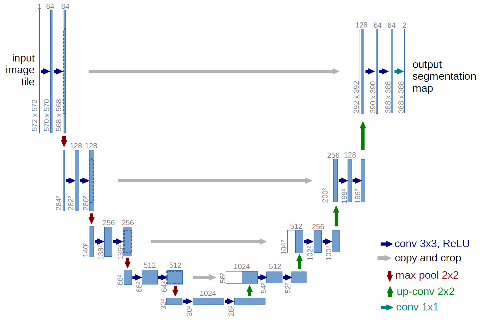

1)	A contracting path similar to an encoder, to capture context via a compact feature map. Here we down-sample the input image to a feature map. The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3x3 (unpadded) convolutions, each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled so that architecture can learn the complex structures effectively. In this path, the model captures the important features from the image and discards the unimportant features, reducing the resolution of the image at each convolution+maxpool layer. (In other words the network learns the “WHAT” information in the image, but loses the “WHERE” information.)

2)	A symmetric expanding path similar to a decoder, which allows precise localisation using transposed convolutions (this also increases the resolution).  This step is done to retain boundary information (spatial information) despite down sampling and max-pooling performed in the encoder stage. Here we up sample the feature map to input image size using learned deconvolution layers. In the expansive path, every step consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path (this ensures that the features that are learned while contracting the image will be used to reconstruct it. The number of expansion blocks is as same as the number of contraction block.), and two 3x3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution. At the final layer, a 1x1 convolution is used to map each 64- component feature vector to the desired number of classes (4 in our case).
(Intuitively, the Decoder recovers the “WHERE” information (precise localization) by gradually applying up-sampling.)

The main contribution of the UNet architecture is the shortcut connections (which can be seen in the image by the horizontal arrows pointing to the right). In the down-sample an image as part of the encoder we lost a lot of information which can't be easily recovered in the encoder part.
UNet proposes an approach to solve this information loss problem. It proposes to send information to every up sampling layer in decoder from the corresponding down sampling layer in the encoder as can be seen in the figure above thus capturing finer information whilst also keeping the computation low. Since the layers at the beginning of the encoder would have more information they would bolster the up sampling operation of decoder by providing fine details corresponding to the input images thus improving the results a lot. While converting an image into a vector, we already learned the feature mapping of the image so why not use the same mapping to convert it again to image. This is the recipe behind UNet. Use the same feature maps that are used for contraction to expand a vector to a segmented image. This preserves the structural integrity of the image which reduces distortion enormously.
The expanding path is symmetric to the contracting path giving the network a shape resembling the English letter ‘U’, hence the name UNet.
Advantages of UNet: computationally efficient, trainable with a small data-set, developed for bio-medical image segmentation.

In our network there are 3 main differences compared to the original Unet:

* Padding of size 1: the padding in our network is necessary to maintain the resolution of the original image during the convolution phase and not to lose any pixels.

* Possibility of using bilinear upsampling instead of transposed convolution. It is a different upsampling technique that uses linear interpolation and the values of all nearby pixels (so not  just its own pixel) to determine its value.

* Batchnormalisation added between the convolutional layer and ReLU: batchnormalisation is a regularisation technique that helps us avoid overfitting. It was discovered in the same year as UNet, hence the reason why the original UNet doesn’t use it.
We also ran tests using the original upsampling and/or padding of 0, but got worse results, hence our best model seemed to be using a padding size of 1 and bilinear upsampling.


#### SegNet
Another network architecture that our Group investigated was the SegNet architecture. The motivation behind the creation of SegNet was that of scene understanding; it was first trained on a road scene dataset with the intended application of autonomous driving. As such, it is designed to be efficient in its use of memory.

Like U-Net, SegNet is a fully convolutional network, with an encoder network and a decoder network. The encoder network of the model consists of 13 VGG16 convolutional layers, and for each of these layers there is a corresponding decoder in the decoder network. Each decoder uses memorised max-pooling indices from its corresponding encoder's feature maps, to upsample the image and produce sparse feature maps, that are then convolved to produce dense feature maps. This process is illustrated in the figure below.

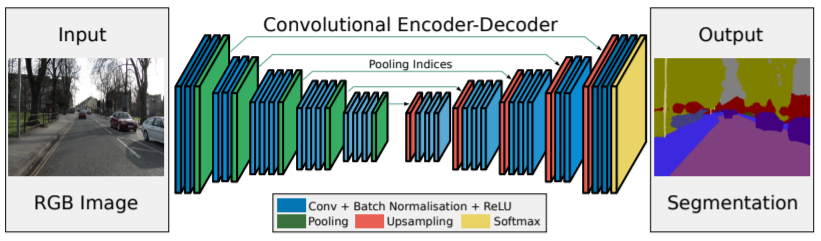

The memorisation of max pooling indices from each pooling layer of SegNet's encoder is what leads SegNet to be efficient in terms of memory use, in comparison to other architectures such as U-Net. This is because in SegNet, only the pooling indices are transferred to the decoder from the encoder, whereas U-Net transfers entire feature maps from its encoder to its decoder. However, this advantage of SegNet is not particularly relevant to this assignment because we are not working with road scene understanding, but with medical image understanding, where the latter does not have embedded systems as the primary use case.

Sources:
* https://towardsdatascience.com/summary-of-segnet-a-deep-convolutional-encoder-decoder-architecture-for-image-segmentation-75b2805d86f5
* https://arxiv.org/pdf/1511.00561.pdf
* https://medium.com/@abhishekkakiak/semantic-segmentation-segnet-a54af19b6d6


#### FCN
FCN, short for Fully Convolutional Network is a popular neural network architecture for semantic image segmentation as recommended by the assignment pdf. The network is similar to Alexnet, VGG and resnet. In fact, the encoder is a pre-trained classification network called VGG. Pooling is introduced after each convolution block, to enable the succeeding block to extract more abstract, class-sailent features from the pooled features. In this architecture, we replace fully connected (FC) layers with 1x1 convolutional layers. Also, the input image is not downsized and so because of max pooling the output has a smaller size than the input. Hence, we need to upsample the input and then calculate the pixelwise output.

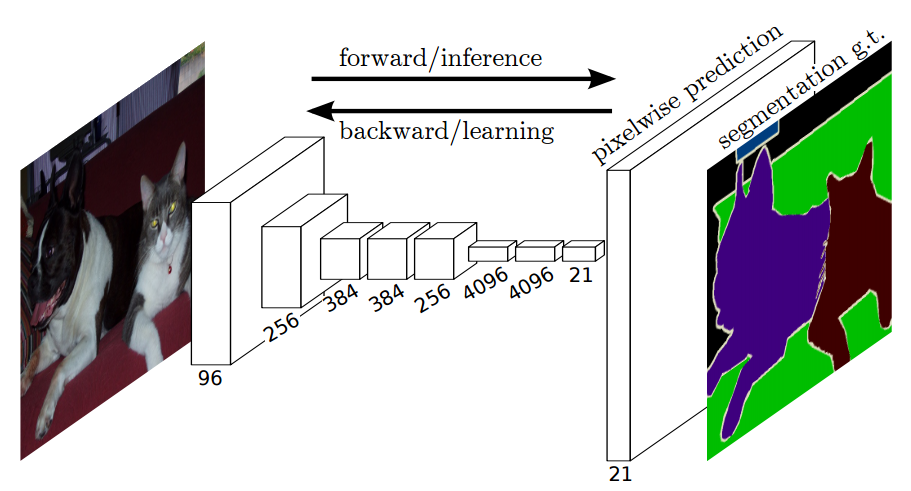


We have decided to use FCN-8s because compared FCN-32s or FCN-16s, the masks are more accurate due to fusing the output. FCN-32s results are very rough because of loss of location information as it is 32x upsampling to make output the same size as input image. FCN-8s has better predictions accuracy because for each pixel, they add results of different layers within the model. This is similar to the ensemble technique used by VGG, Alexnet and googlenet except they add results of multiple models instead.


Sources:
* https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf
* https://meetshah1995.github.io/semantic-segmentation/deep-learning/pytorch/visdom/2017/06/01/semantic-segmentation-over-the-years.html#sec_fcn







For data loading we used the given TrainDataset (for the training and evaluation set, these had images with given ground truths) and TestDataset (for the test set) to make a dataset out of the given images.  Once we had the datasets, we used the provided DataLoader method as provided originally, to get our images in the required format (distributing them into different batches). We kept num workers 4 (apart from one test case using the later mentioned augmented dataset, where we had to set it to 0 to make it work), as that doesn't affect training and seemed to perform well on our platforms. TrainDataset and TestDataset load training or test data into memory,  while the DataLoader object fetches data from a Dataset and serves the data up in batches. The DataLoader also paralellises data loading and supports automatic batching, which makes it super efficient.
https://www.journaldev.com/36576/pytorch-dataloader

## Experiment
(40\%): *describe the experiments you carried out to optimize your
network’s generalization performance and present the results you obtained. Explain in detail how you used the training, validation and test data sets. The results should be presented in a statistically rigorous manner.*

During our experiments, we used the training set to train the parameters of the architecture as it can be seen in Section 2.4. In the same section we also use the validation set, where we check how the model performs on unseen data after each optimisation step (this is done by checking the average loss per sample for each epoch). We later also used the validation set to implement early stopping **(we will write about this later in more detail)**. After the training and evaluation ended, we saved the model (we also separately saved the model with the smallest validation loss). For testing, we load this model and apply it on the unseen test set, to obtain the predicted masks. For testing we always used a batch size of $1$, but this doesn't make a difference since we just applied the model onto the test images. But because of the batch size of $1$ we can take the argmax of the 0th dimension when converting to a mask, since the dimension of the "batch " after squeezing is (4,96,96). These masks are then saved locally, and from them we can obtain the csv file required for Kaggle. We decided to only submit our best results because of the daily limit on Kaggle submissions.

*For training, you are expected to show the following components: network architecture, loss function, optimizer and training processing. For the training process, you should show you understanding on the number of epochs required to train you network, as well as data loading, It is also necessary to show correct training mode (model.train), zero gradient (optimizer.zero grad), backpropagation (loss.backward), optimization (optimizer.step), etc.*

The network architecture can be seen in Section 2.2, loss function and optimiser in Section 2.3, training and validation in Section 2.4, all with comments next to the source code explaining the use/purpose of the code added by our group.

With the help of the given categorical_dice function, we decided to implement the dice similarity score (as seen in the code) for two reasons. First of all, it was useful to see what dice similarity we got on the evaluation set, as we expected this to be similar/relevant to what we would get on the test set. Secondly, since there is no common metric for loss functions, dice similarity also served as a benchmark. What we mean by this is that a loss value of $0.001$ for one loss function might not be better than a loss value of $0.1$ for a different loss function and we can compare the meanings of these values easily if we have their corresponding dice similarity scores.

We also implemented the different loss functions mentioned earlier and used the aforementioned optimisers.

### Approach to Testing

Since this task was very complex, we could have tested tens of thousands of combinations of hyperparameters and parameters (apart from the later mentioned, we could have varied the number of layers in the network or the kernel size, stride too, however we thought these had a smaller affect than the later mentioned).

Therefore, the structure of our experiments was as such; quick preliminary 'tests' were carried out, which sketched out rough values of the hyperparameters for use in structured group testing. Then, these group tests  determined underlying trends, which were applied in the final test stage to finely tune the hyperparameter values.

##### **Preliminary Tests**
The preliminary tests were useful in providing the scope of hyperparameter values that were worth detailed testing in the group stage. We selected a number of architectures, optimisers and loss functions to experiment with. We tried runs with batch sizes ranging from $1$ to $5$, as well as $10$ and $20$, and discovered that batch sizes of $1$ and $20$ gave evidently poor/inconsistent validation loss and dice similarities, so would be a waste of time to investigate further. Batch sizes of $4$ and $10$ were chosen for detailed group testing, since these appeared more effective, and it was not clear from preliminary tests which was superior; batch sizes surrounding $4$ and $10$ were omitted due to being very similar or worse based on these rough preliminary tests. We wanted to test these moderately separated values in order to better 'test the waters' for the batch size.

##### **Overview of Group 1 & 2 testing**
We split ourselves into two groups to conduct two different sets of tests. Group 1 focused on the effect of network architecture choice and batch size, from those selected in the preliminary tests. Group 2 focused on investigating various loss functions and optimisers, to determine the best choices for the final stage. During preliminary tests, we achieved reasonably good results of $89\%$ dice similarity on Kaggle with a batch size of $4$, U-Net architecture, Adam as the optimiser (with default paramseters) and the cross entropy loss function. Thus, the second group aimed to tune the hyperparameters of the optimisers and the loss functions themselves, with a fixed architecture of U-Net and a fixed batch size of $4$.

After the two groups ran their tests, we discussed the trends we found and ended up with a small number of combinations of hyperparameters, which we tried to further tune to increase our best dice similarity score. When running the experiments, we logged the average training and validation loss per sample and the average dice similarity for each epoch and analysed the performance of our model this way.

### Group 1: Experiments & Results

Group 1 focused primarily on determining the best choice of network architecture and batch size from those found in the preliminary tests. These are key hyperparameters to identify any underlying trends for, and as such, many tests were carried out for the $3$ chosen networks (U-Net, SegNet and FCN8) and $2$ batch sizes ($4$ and $10$). $4$ loss functions (Crossentropy, Comboloss, Diceloss, Focalloss with default parameters) and $4$ optimisers (Adam, AdamW, AverageSGD, Adadelta with default parameters) were used to diversify the test cases for Group 1; the choice of these loss functions and optimisers was due to all of these working well during preliminary testing. Loss functions and optimisers were not the main focus for Group 1; however, any results found for these hyperparameters were discussed in order to aid in our findings, and have been graphed below.

Therefore, using grid search testing, Group 1 completed $3 \cdot 2 \cdot 4 \cdot 4 = 96$ experiments. These were carried out with an epoch size of $20$, because it ran long enough to give good results and (roughly) indicate the peak accuracy, while not consuming too much time for each experiment (as higher epoch numbers would). The graphs investigating a given hyperparameter were constructed by separating the $96$ experiments into groups based on the values of that hyperparameter, then averaging these groups into singular runs to plot on the graph. For example, in the batch size graph, we see an averaged run for batch size $4$ and batch size $10$; each of which are formed from $96 / 2 = 48$ experiments across the same combinations of networks, loss functions and optimisers.

After our experiments, we saw the following trends from Group 1's tests:

##### **Batch size**

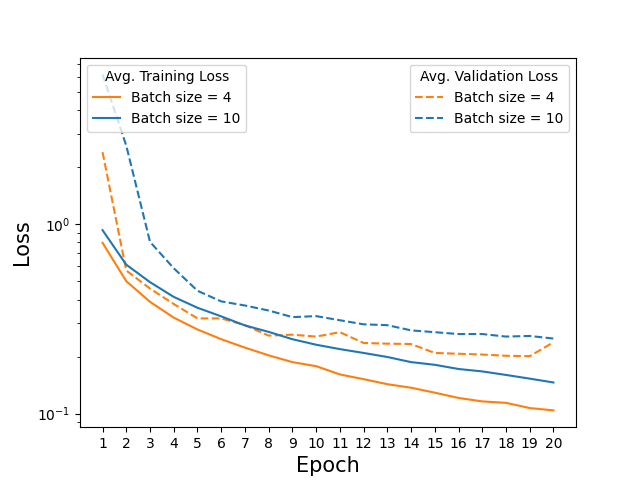

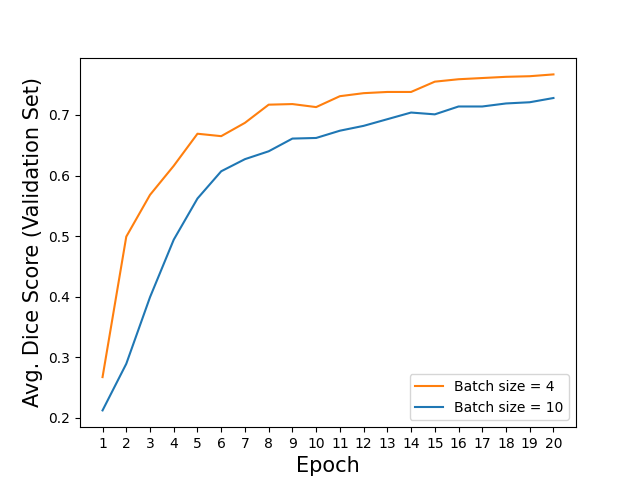

* Batch size of $4$ gave better average results than a batch size of $10$. As well as this, the highest dice similarity scores on the validation set were obtained with this batch size.

##### **Network Architecture**

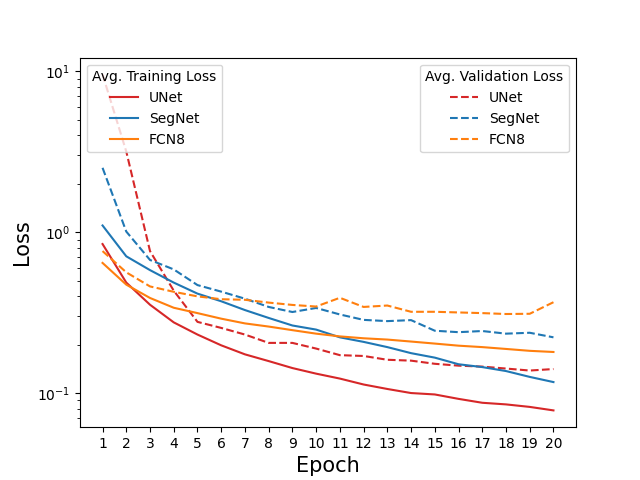

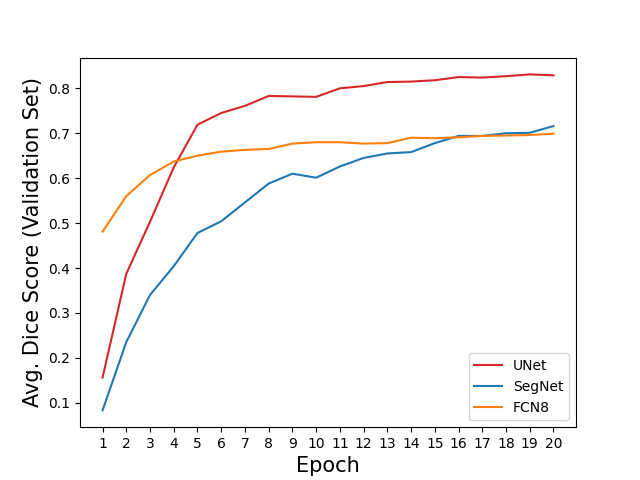

* UNet gave the best results on average, and also obtained the highest dice similarity scores on the validation set.



##### **(Some) Loss functions**

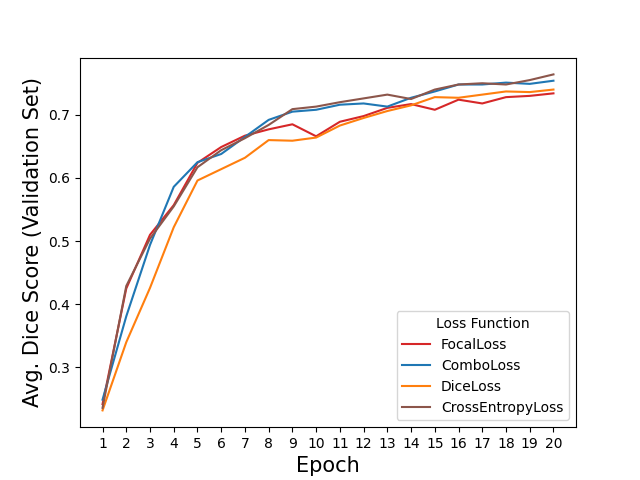

* The loss functions seemed to give similar results on average, but the highest dice similarity scores were obtained by Comboloss with weights 0.25,0.75,0.75,0.75. **keep ?**(we also tried 1-dice similarity score as our loss function, , which also gave promising results so we tried some test with that in the latter stages as well, however it tended to be sligtly worse than comboloss with ce ratio of 0.5)**keep ?**

##### **(Some) Optimisers**

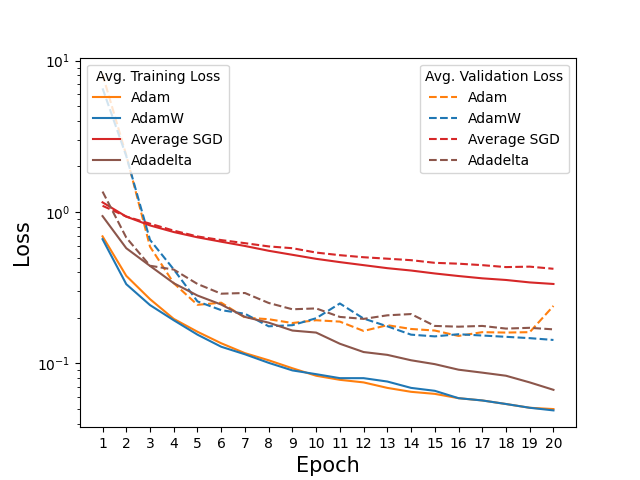

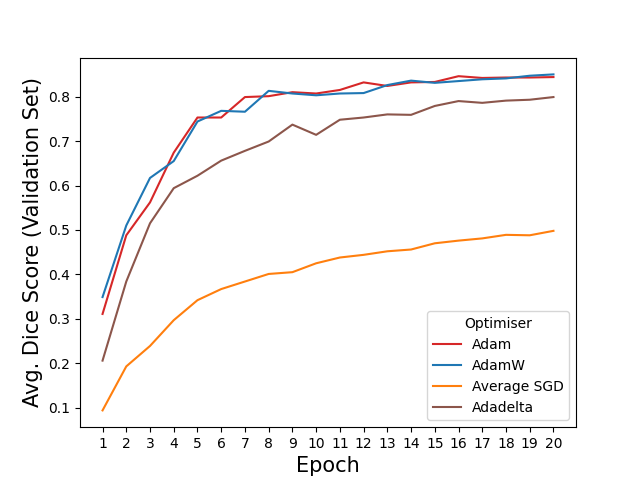

* On average, Adam and AdamW performed better than Adadelta and a lot better than Average SGD. Adam and AdamW gave similar highest dice similarity scores. **keep ?** We also ran tests with Adagrad but it performed worse than Adam and AdamW) **keep ?**


### Group 2 Results
Group 2 performed experiments to find the best loss function and optimiser for the problem. We first did some research into the best ones to try for this problem. (insert research here). We found ……………………….. could be used. We discounted Spare Adam because …………, and LBFGS because it was too memory intensive, so we couldn’t run it on the hardware we had available.
As there are so many potential optimisers, before we could fine tune parameters, we had to narrow the number we were looking that. To do that we ran each optimiser with their default parameters. We ran the tests using the UNet network, with batch size of 4, because at the start of the experiment it was clear from Group 1’s tests that those would give the best performance. We ran two tests and averaged the runs, to prevent any anomalies skewing the data too much. We also ran the tests using both the Cross Entropy Loss function, and the Dice Loss function, to see if different optimisers performed better with different loss functions. The Dice similarity scores from these tests can be seen on this graph.


Its clear to see from the graph that there are a few optimisers that far outperform the others: Adam, AdamW and Adadelta. Adamax also performs quite well.
From these results it was clear which optimisers had the potential to give us the best performance, so we set out a series of experiments to finetune the parameters of Adam, AdamW, and Adadelta.
INSERT writeup and graphs of finetunes experiments here.
Once we had optimised each of these optimisers, we found that Adam, AdamW and Adadelta all performed very well, so we decided to use all three in the final stage of testing.
Next we carried out experiments to find the best performing Loss Function. Our research showed that  INSERT RESEARCH HERE would be appropriate. Again, we had to narrow down the potential number of loss functions we were testing before we could fine tune parameters (due to the limited time we had). We fixed the optimiser as Adam (as we know it performs well from the previous tests), and ran experiments using each loss function with their default parameters, with UNet and batch size 4 again, over 25 epochs. We ran two tests for each and averaged the results togeher. The Dice Similarity scores from these experiments can be seen on the graph.









It can be seen here that all loss functions produce similar Dice Similarity scores. Dice converged to a good score the fastest, but never gets as higher as cross entropy or combo loss. Cross entropy loss reached the highest point, but didn’t stay as consistently high as combo loss. Cross Entropy and Combo Loss However, as they all were quite similar in terms of performance, we decided to carry out experiments to optimise them all, in case optimising them made some of them perform better than others.
The outcomes of these experiments were…………

#####Cross Entropy
The only hyperparameter for Cross Entropy Loss is the weights of each class.In our initial testing we found that since class 0 (the background in the image data) shows up more frequently than the others it should be weighted less and the other 3 seemed to have roughly the same frequency.The following graph shows the results of our testing for cross entropy.
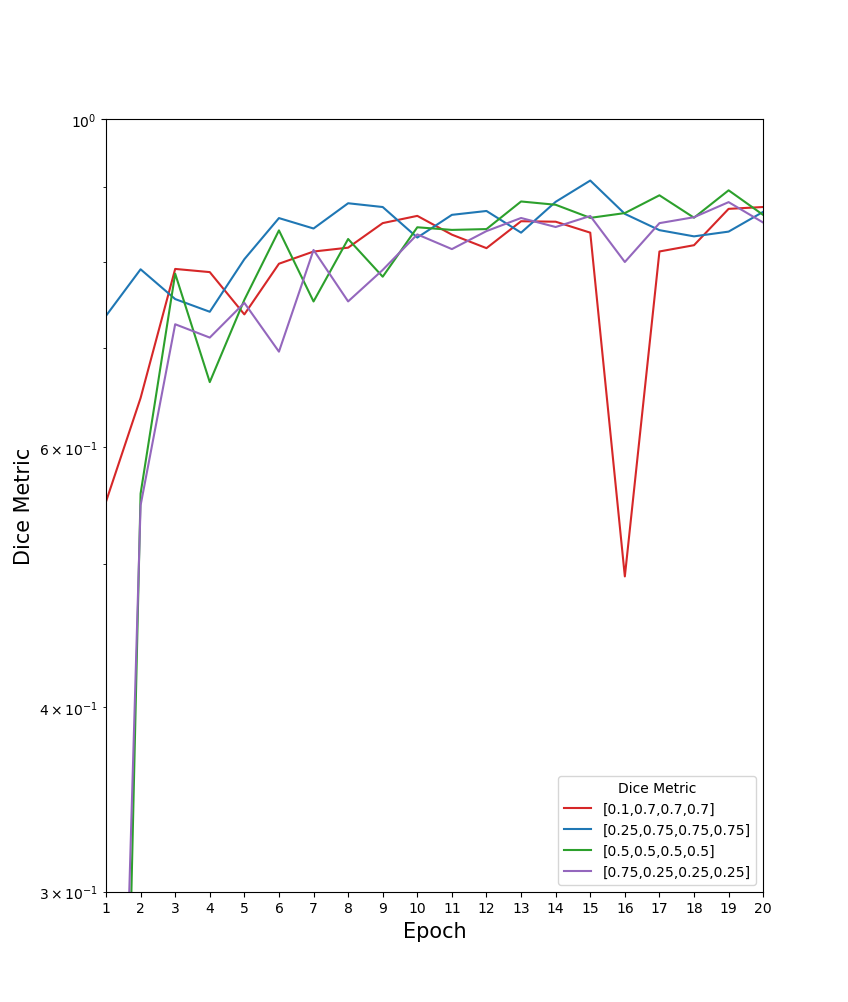

#####Focal Loss
As Focal Loss is an adaptation of Cross Entropy, it uses the same class weights as Cross Entropy Loss. The other hyperparameter is the value of gamma. A study in [5] Focal Loss for Dense Object Detection, Tsung-Yi Lin, Priya Goyal, Ross Girshick, KaimingHe, Piotr Dollar suggests gamma=2 gives the best results, but their use case was different, so we’d still like to run tests for ourselves on our data. For these tests we used the weights we found to be most effective in Cross Entropy loss, and varied gamma. The results can be seen in this graph.
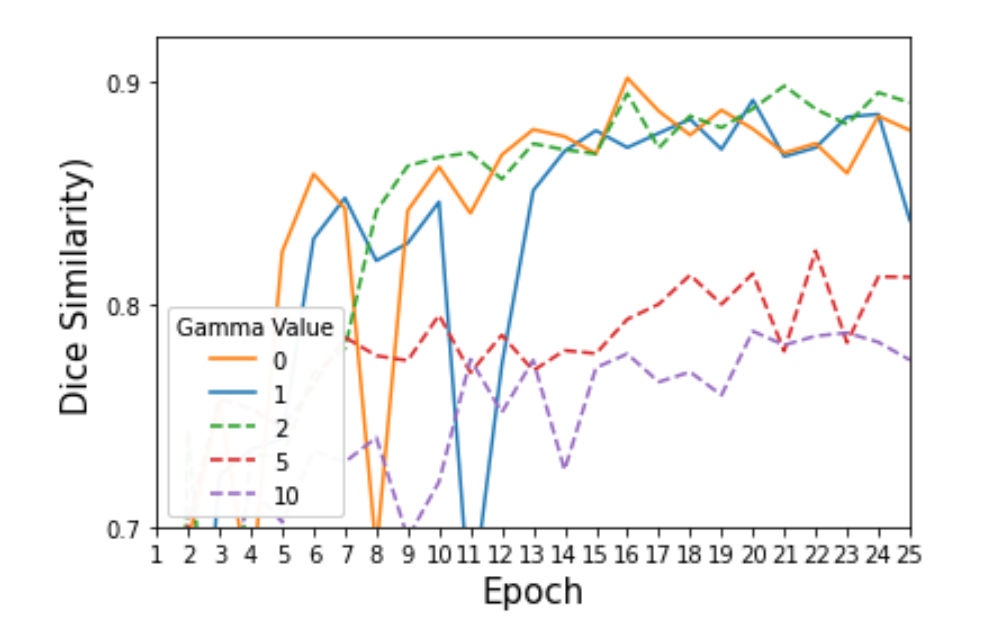!

It can be seen that values for gamma around 2 provide the best performance, so we then ran tests for values around 2.

[gamma2.png](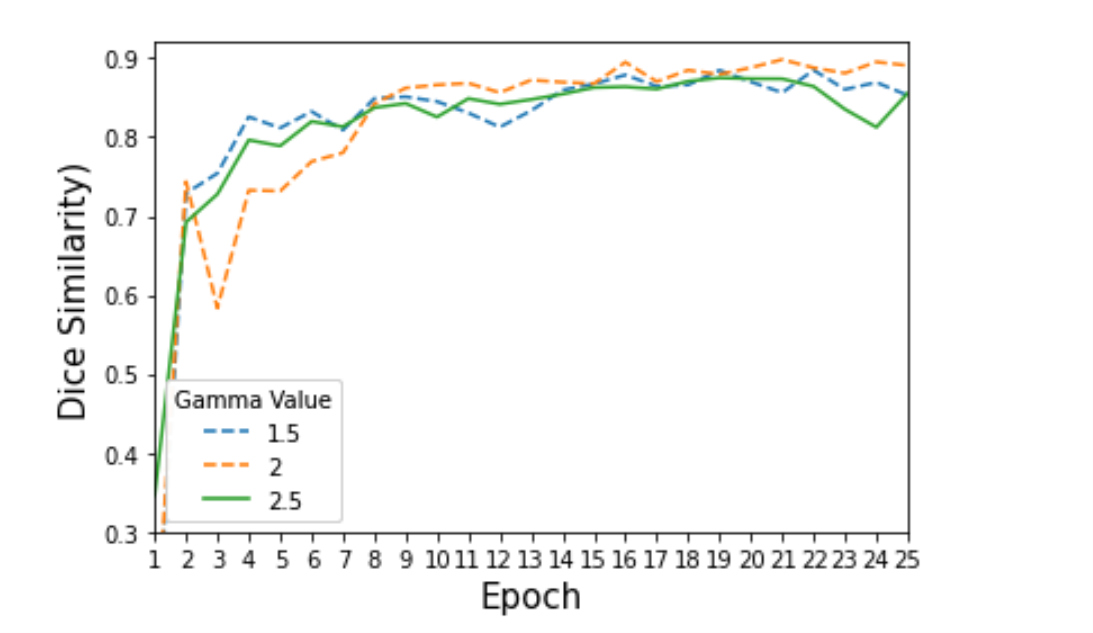)

#####Dice Loss
There are no hyperparameters for Dice loss to tune.
Focal Dice Loss
Focal Dice Loss uses a weighted average of focal and dice. Therefore we used the value of gamma that we found to be most effective for focal loss, and varied the ratio between the focal and dice parts of the loss function. The results can be seen in this graph.
Combo Loss
Combo Loss uses a weighted average of Cross Entropy Loss and Dice Loss. Therefore we used the weights we had found most effective for Cross Entropy Loss, and varied the CE_Ratio to try and improve performance. The results can be seen on this graph.
After optimising all five of these loss functions, we found Combo Loss, Cross Entropy Loss and Focal Loss to be the best, so we decided to use these in the final stage of testing.

#####Adam
When testing Adam(and AdamW) we focused on changing the hyperparameters of: learning rate and weight decay. Changing the learning rate, we found, made a big difference on the eventual dice metric that we got for the network. We found that increasing the learning rate decreased the overall accuracy of the network, as can be seen on the following graph:
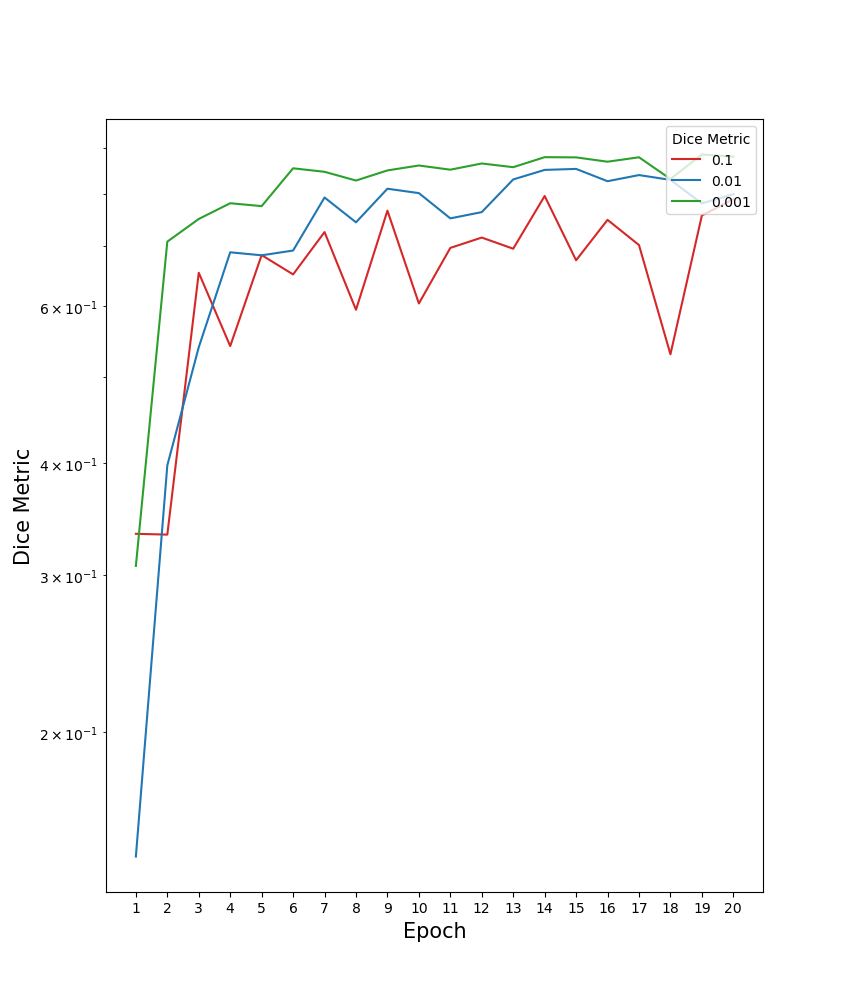

#####AdamW
For the AdamW optimiser, increasing the learning rate drastically decreased performance,similar to Adam, whilst decreasing it meant it converged too slowly to see any decent performance within 50 epochs. Changing the weight decay parameter showed similar results. Enabling Amsgrad with AdamW did not result in an noticable performance changes.
AdamW:

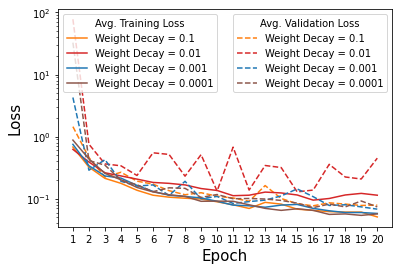

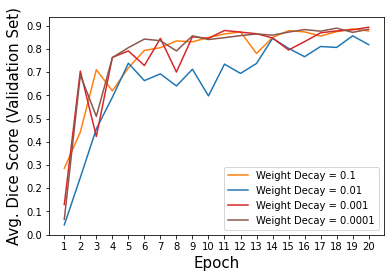

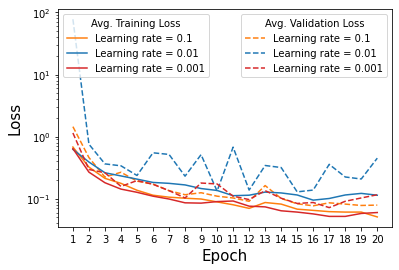

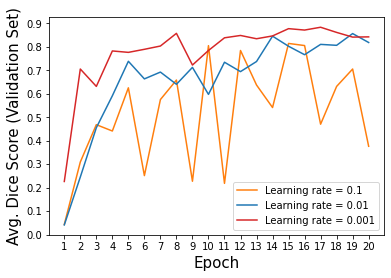

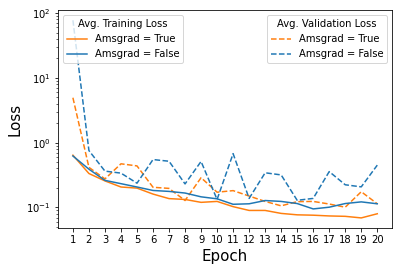

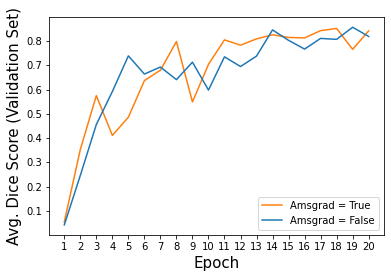



### The Final Stage


Once Group 1 had identified the best model and batch size to use, and Group 2 had identified the best optimisers, loss functions and found the best hyperparameters for them, the final stage was to run tests using a combination of them.

In order to maximise the Dice similarity score, we did some modifications compared to the first stage. Firstly, we increased the number of epochs to 50 (we also ran some experiments with an epoch number of 100, however after 50 epochs, the model didn't improve, moreover, it started overfitting. In fact, most of the times the best performing model was obtained no later than 35-40 epochs.)

We introduced early stopping on the validation set by stopping if the validation loss increased 3 times in a row, which made sure the number of epochs used in training was appropriate. The fact that we also save the model at the smallest validation loss could also be considered as another form of early stopping.

We tried out dropout with a rate of 0.1 in the network for a few test cases. This seemed to slightly reduce the dice similarity score, which isn't suprising, according to https://www.researchgate.net/publication/338741810_Dropout_vs_batch_normalization_an_empirical_study_of_their_impact_to_deep_learning But the fact that dropout does not improve our model isn't a problem or a surprise since batch normalisation has similar generalisation affects as dropout.  Also, dropout in a CNN doesn't work in the same way as for a fully connected network, thus it doesn't always result in a "better" network. https://towardsdatascience.com/dropout-on-convolutional-layers-is-weird-5c6ab14f19b2 It is also recommended not to use dropout when batch normalisation is done. https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/ https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html Furthermore, batch normalisation can be more efficient, because convolutional networks have a small number of paramaters. (kdnuggets link)

We also increased the training set by augmenting the data with running the following code locally and generating extra training data: (this code generated the training masks, for the training images, we need to replace "mask" by "image" when opening the image, and remove "_mask" when saving the images)

   



```
from PIL import Image
import PIL
def transformSave(num):
    im = Image.open(r"C:\CW2\data\test\mask\cmr"+str(num)+"_mask.png")
    im.rotate(90).save(r"C:\CW2\augmented\cmr"+str(num+200)+"_mask.png")
    im.rotate(180).save(r"C:\CW2\augmented\cmr"+str(num+400)+"_mask.png")
    im.rotate(270).save(r"C:\CW2\augmented\cmr"+str(num+600)+"_mask.png")
    im.transpose(Image.FLIP_LEFT_RIGHT).save(r"C:\CW2\augmented\cmr"+str(num+800)+"_mask.png")
    im.transpose(Image.FLIP_LEFT_RIGHT).rotate(90).save(r"C:\CW2\augmented\cmr"+str(num+1000)+"_mask.png")
    im.transpose(Image.FLIP_LEFT_RIGHT).rotate(180).save(r"C:\CW2\augmented\cmr"+str(num+1200)+"_mask.png")
    im.transpose(Image.FLIP_LEFT_RIGHT).rotate(270).save(r"C:\CW2\augmented\cmr"+str(num+1400)+"_mask.png")
for i in range(1,101):
    transformSave(i)
```
This code rotated the original image by $90^\circ, 180^\circ,270^\circ $ and mirrored it and rotated it by $90^\circ, 180^\circ,270^\circ $ (all separately), thus we had $8$ times the original training data. This resulted in a $2\%$ increase in the dice similarity of our masks on Kaggle. (Compared to the best result we had, both were run with default Adam, comboloss (ci weight 0.5), weights (0.26,0.75,0.75,0.75) and UNet. For batch size, here we used 40, as for a larger training set we of course need a larger batch size. We also testedbatch sizes of 32 and 50, however 32 gave inconsistent results and 50 gave worse dice similarity scores (and we could just make it work, because it often caused memory problems) We could have tried batch sizes that are not factors of the training data set size (with using drop_last=True in the DataLoader), however we thought small differences in the batch size wouldn't have a large impact on the performance, thus we tested these batch sizes. Smaller and larger batch sizes were disregarded because of our bad experiences in stage 1 testing with batch sizes under 5% or over 7% of the training data.






Out of interest we also ran some test with a batch size of $5$ and $3$, however $4$ performed better thus we kept that as our batch size.

-As a quick summary, our set of test for the second stage of testing were as follows:

\begin{array}{|l|l|l|l|l|}
\hline
epochs & architecture                        & loss function (and its hyperparameters)                         & optimiser (and its hyperparameters) & batch size \\ \hline
50     & UNet                                & Combo (ce ratio 0, weights: {[}0.25,0.75,0.75,0.75{]})          & Adam (default)                      & 4          \\ \hline
50     & UNet                                & Combo (ce ratio 0.25, weights: {[}0.25,0.75,0.75,0.75{]})       & Adam (default)                      & 4          \\ \hline
50     & UNet                                & Combo (ce ratio 0.5, weights: {[}0.25,0.75,0.75,0.75{]})        & Adam (default)                      & 4          \\ \hline
50     & UNet                                & Combo (ce ratio 0.75, weights: {[}0.25,0.75,0.75,0.75{]})       & Adam (default)                      & 4          \\ \hline
50     & UNet                                & Combo (ce ratio 0.25, weights: {[}0.25,0.75,0.75,0.75{]})       & AdamW (default)                     & 4          \\ \hline
50     & UNet                                & Combo (ce ratio 0.5, weights: {[}0.25,0.75,0.75,0.75{]})        & AdamW (default)                     & 4          \\ \hline
50     & UNet                                & Combo (ce ratio 0.75, weights: {[}0.25,0.75,0.75,0.75{]})       & AdamW (default)                     & 4          \\ \hline
50     & UNet (with dropout 0.1)             & Combo (ce ratio 0.5, weights: {[}0.25,0.75,0.75,0.75{]})        & Adam (default)                      & 4          \\ \hline
50     & UNet                                & Combo (ce ratio 0.5, weights: {[}0.25,0.75,0.75,0.75{]})        & Adam (default)                      & 3          \\ \hline
50     & UNet                                & Combo (ce ratio 0.5, weights: {[}0.25,0.75,0.75,0.75{]})        & Adam (default)                      & 5          \\ \hline
50     & UNet (with padding 0)               & Combo (ce ratio 0.5, weights: {[}0.25,0.75,0.75,0.75{]})        & Adam (default)                      & 4          \\ \hline
50     & UNet (with non bilinear upsampling) & Combo (ce ratio 0.5, weights: {[}0.25,0.75,0.75,0.75{]})        & Adam (default)                      & 4          \\ \hline
100    & UNet                                & Focal (gamma=2, alpha=0.75 weights: {[}0.25,0.75,0.75,0.75{]})  & Adam (default)                      & 4          \\ \hline
50     & UNet                                & Combo (ce ratio 0.5, weights: {[}0.25,0.75,0.75,0.75{]})        & Adagrad (default)                   & 4          \\ \hline
50     & UNet                                & Combo (ce ratio 0.5, weights: {[}0.25,0.75,0.75,0.75{]})        & Adam (default)                      & 4          \\ \hline
50     & UNet (with augmented data)          & Combo (ce ratio 0.5, weights: {[}0.25,0.75,0.75,0.75{]})        & Adam (default)                      & 40         \\ \hline
50     & UNet (with augmented data)          & Combo (ce ratio 0.5, weights: {[}0.25,0.75,0.75,0.75{]})        & Adam (default)                      & 32         \\ \hline
50     & UNet (with augmented data)          & Combo (ce ratio 0.5, weights: {[}0.25,0.75,0.75,0.75{]})        & Adam (default)                      & 50         \\ \hline
50     & UNet (with augmented data)          & Focal (gamma=2, alpha=0.75, weights: {[}0.25,0.75,0.75,0.75{]}) & Adam (default)                      & 50         \\ \hline
50     & UNet (with augmented data)          & Combo (ce ratio 0, weights: {[}0.25,0.75,0.75,0.75{]})          & Adam (default)                      & 50         \\ \hline
\end{array}

The best result we got on the Kaggle leaderboard is 0.90700 which we got with the following way: UNet architecture, augmented data set (the way we described it earlier), Adam optimiser with default parameters, Comboloss loss function (ce ratio 0.5, weights [0.25,0.75,0.75,0.75]), batch size 40, 50 epochs (best network was achieved on the 31st epoch).




## Conclusion
(10\%): summarize your key findings, including which factors proved most crucial, and what was the best generalization performance you achieved.

From our experiments we could see that all hyperparameters and architectures had quite an impact on the dice similarity we got, and arriving to a good combination of those was quite a challenging task. ...